In [29]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np

### example of DoG filter

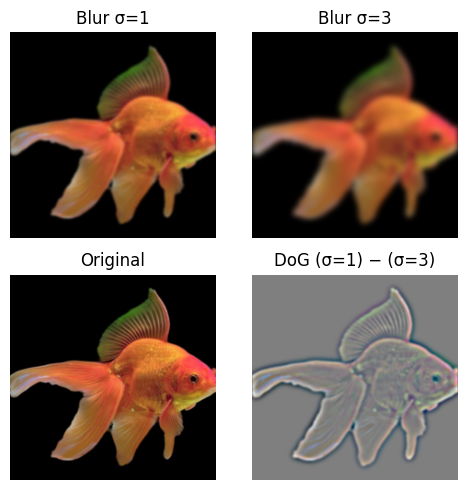

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = Image.open("goldfish.jpg").convert("RGB")

to_tensor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),        # C×H×W in [0,1]
])

img = to_tensor(image).unsqueeze(0).to(device)  # [1,3,224,224]
# print("Image", img)

# ---- Build Gaussian kernels and apply DoG ----
def kernel_size_for_sigma(sigma: float) -> int:
    # 3σ radius → size = 2*ceil(3σ)+1 (odd, captures most of Gaussian mass)
    return int(2 * (3 * sigma).__ceil__() + 1)

def gaussian_kernel(kernel_size: int, sigma: float, channels: int = 3) -> torch.Tensor:
    ax = torch.arange(kernel_size, device=device) - (kernel_size - 1) / 2.0
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    kernel = torch.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / kernel.sum()
    # depthwise conv weight shape: [C,1,k,k]
    return kernel.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)

sigma1, sigma2 = 1, 3
ks1, ks2 = kernel_size_for_sigma(sigma1), kernel_size_for_sigma(sigma2)

g1 = gaussian_kernel(ks1, sigma1, channels=img.shape[1])
g2 = gaussian_kernel(ks2, sigma2, channels=img.shape[1])

with torch.no_grad():
    blur1 = F.conv2d(img, g1, padding=ks1 // 2, groups=img.shape[1])  # depthwise
    blur2 = F.conv2d(img, g2, padding=ks2 // 2, groups=img.shape[1])
    dog   = blur1 - blur2 

    # For visualization: min-max to [0,1] per-image
    mn = dog.amin(dim=(1, 2, 3), keepdim=True)
    mx = dog.amax(dim=(1, 2, 3), keepdim=True)
    dog_vis = (dog - mn) / (mx - mn + 1e-8)

# ---- Show original vs DoG ----
to_numpy = lambda t: t.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(5, 5))

plt.subplot(2, 2, 1); plt.title(f"Blur σ={sigma1}");   plt.imshow(to_numpy(blur1));   plt.axis("off")
plt.subplot(2, 2, 2); plt.title(f"Blur σ={sigma2}"); plt.imshow(to_numpy(blur2));   plt.axis("off")
plt.subplot(2, 2, 3); plt.title("Original");   plt.imshow(to_numpy(img));     plt.axis("off")
plt.subplot(2, 2, 4); plt.title(f"DoG (σ={sigma1}) − (σ={sigma2})"); plt.imshow(to_numpy(dog_vis)); plt.axis("off")

plt.tight_layout(); plt.show()

In [31]:
torch.meshgrid(torch.arange(5), torch.arange(5), indexing="ij")  # For PyTorch 1.12+ compatibility

(tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]]),
 tensor([[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]]))

### winners take all

In [48]:
B, C, H, W = 1, 5, 2, 3  # B, C, H, W
K = 2

prelimy = torch.tensor(
    [[[[ 0.2, -0.1,  0.3],
       [ 0.5,  0.1, -0.2]],
      [[-0.4,  0.6,  0.2],
       [ 0.3, -0.7,  0.1]],
      [[ 0.8, -0.9,  0.0],
       [-0.1,  0.4,  0.2]],
      [[ 0.1,  0.2,  0.9],
       [ 0.7,  0.3, -0.5]],
      [[-0.2,  0.5,  0.4],
       [ 0.0,  0.6,  0.2]]]]
).float()  # [1, 5, 2, 3]

thres = torch.zeros(1, C, 1, 1)  # [1, 5, 1, 1]

In [ ]:
# --- Safer top-K + positive binarization ---
with torch.no_grad():
    realy = prelimy - thres
    vals, idx = torch.topk(realy, K, dim=1)        # pick exact top-K per (h,w)
    mask = torch.zeros_like(realy, dtype=torch.bool)
    mask.scatter_(1, idx, True)
    winners = (mask & (realy > 0)).float()

print("prelimy[0,:,0,0] =", prelimy[0,:,0,0])  # 5 channels at (h=0,w=0)
print("winners[0,:,0,0] =", winners[0,:,0,0])  # exactly K=2 ones among the positive top-K

# Quick check: per spatial location, count of winners is <= K (==K if top-K are positive)
per_loc_counts = winners.sum(dim=1)
print("winners per (h,w):\n", per_loc_counts[0])  # shape [H,W]

prelimy[0,:,0,0] = tensor([ 0.2000, -0.4000,  0.8000,  0.1000, -0.2000])
winners[0,:,0,0] = tensor([1., 0., 1., 0., 0.])
winners per (h,w):
 tensor([[2., 2., 2.],
        [2., 2., 2.]])


In [86]:
idx.shape, prelimy.shape

(torch.Size([1, 2, 2, 3]), torch.Size([1, 5, 2, 3]))

#### `torch.topk` example

In [ ]:
# 遍历除了`dim`之外的所有轴, 如prelimy[0,:,0,0], prelimy[0,:,0,1], prelimy[0,:,1,0], ..., 在每个frame上取出top-K个values与对应的indexes
# 假如dim=1, values与idx的shape为[-,dim(K),-,-],`-`为原始维度


#### `torch.scatter` example

In [78]:
num_classes = 4
labels = torch.tensor([2, 0, 1])      # class ids per row (batch=3)

one_hot = torch.zeros(6, 6)  # [3,4] zeros

# one_hot.scatter_(dim, index, value)
# 把指定value添加到dim维度的index位置
one_hot.scatter_(0, labels.unsqueeze(1), 1.0)  
print(one_hot)
print('==================')
one_hot.scatter_(1, labels.unsqueeze(1), 1.0)  
print(one_hot)



tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
